In [1]:
!python3 -m pip install konlpy

In [2]:
!pip install sentencepiece

In [3]:
!sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
python3-dev is already the newest version (3.6.7-1~18.04).
openjdk-8-jdk is already the newest version (8u312-b07-0ubuntu1~18.04).
python3-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.


In [4]:
!sudo apt-get install curl git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
git is already the newest version (1:2.17.1-1ubuntu0.9).
0 upgraded, 0 newly installed, 0 to remove and 69 not upgraded.


In [5]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import konlpy
import warnings
warnings.filterwarnings(action='ignore')
import os
import re
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 네이버 영화 감정분석 데이터 불러오기

In [8]:
path = "/content/drive/MyDrive/naver_movie_text"
train_data = pd.read_table(path + "/ratings_train.txt")

test_data = pd.read_table(path + "/ratings_test.txt")

train = train_data.copy()
test = test_data.copy()

In [9]:
train_data[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [10]:
print('훈련용 데이터: {}개 , 시험 데이터: {}개'.format(len(train_data),len(test_data)))

훈련용 데이터: 150000개 , 시험 데이터: 50000개


# 2. 데이터 분석하기

### (1) train_data 분석

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### 결측치 확인

In [12]:
train_data['document'][train_data['document'].isnull()]

25857     NaN
55737     NaN
110014    NaN
126782    NaN
140721    NaN
Name: document, dtype: object

#### 중복되지않는 고유한 데이터 확인하기

In [13]:
print('document에서 중복 되지않는 문장의 개수: {}개'.format(train_data['document'].nunique()))
print('label의 종류: {}가지'.format(train_data['label'].nunique()))

document에서 중복 되지않는 문장의 개수: 146182개
label의 종류: 2가지


In [14]:
train_data.groupby('label').size()

label
0    75173
1    74827
dtype: int64

### (2) test_data 분석

In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


#### 결측치 확인

In [16]:
test_data['document'][test_data['document'].isnull()]

5746     NaN
7899     NaN
27097    NaN
Name: document, dtype: object

#### 중복되지않는 고유한 데이터 확인하기

In [17]:
print('document에서 중복 되지않는 문장의 개수: {}개'.format(test_data['document'].nunique()))
print('label의 종류: {}가지'.format(test_data['label'].nunique()))

document에서 중복 되지않는 문장의 개수: 49157개
label의 종류: 2가지


In [18]:
test_data.groupby('label').size()

label
0    24827
1    25173
dtype: int64

# 3. 데이터 전처리

## 전처리 과정

a. 중복 제거

In [19]:
train_data.drop_duplicates(subset=['document'], inplace=True)

b. 결측치 확인

In [20]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


c. 결측치 제거

In [21]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


d. 한글과 띄어쓰기만 남기고 다 지우기

In [22]:
train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

train_data[:10]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


e. 결측치 재확인

In [23]:
train_data['document'].replace("", np.nan, inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

146182
id            0
document    391
label         0
dtype: int64


f. 결측치 추가제거

In [24]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145791


test 데이터도 똑같이 전처리

In [25]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how = 'any')

# 4. 토큰화 및 불용어 제거

불용어

In [26]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

## SentencePiece

In [27]:
import sentencepiece as spm

### 문장의 길이를 확인하는 함수

In [28]:
length_list = []

def text_length(train_data):
  min_len = 999
  max_len = 0
  sum_len = 0

  for sen in train_data['document']:
    length = len(sen)
    length_list.append(length)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
  print("문장의 최단 길이: ", min_len)
  print("문장의 최장 길이: ", max_len)
  print("문장의 평균 길이: ", sum_len // len(train_data['document']))
  print('')
  sentence_length = np.zeros((max_len), dtype=np.int)
  
  for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

  plt.figure(figsize=(10,6))
  plt.bar(range(max_len), sentence_length, width=1.0)
  plt.axvline(x=50, color='red', linewidth=2)
  plt.text(50, 0.58, 50, color='red')
  plt.axvline(x=60, color='blue', linewidth=2)
  plt.text(60, 0.58, 60, color='blue')
  plt.axvline(x=70, color='green', linewidth=2)
  plt.text(70, 0.58, 70, color='green')
  plt.title("Sentence Length Distribution")
  plt.show()

문장의 최단 길이:  1
문장의 최장 길이:  140
문장의 평균 길이:  33



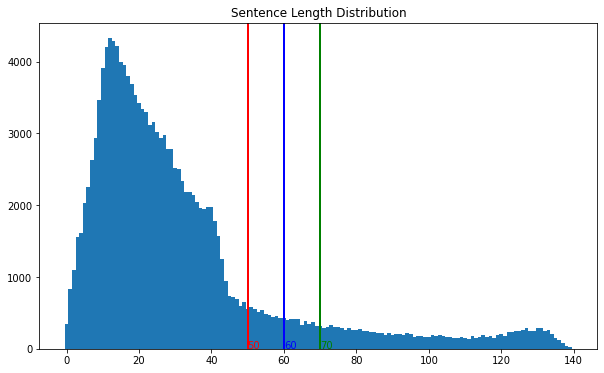

In [29]:
text_length(train_data)

In [30]:
# 표준편차
np.std(length_list)

27.941635359621714

In [31]:
def optimization_len(cut_len, raw):
    cnt = 0
    for sen in raw:
        if(len(sen) <= cut_len):
            cnt = cnt + 1
    print('전체 댓글 길이 중 {}이하에 포함되는 댓글 {}%'.format(cut_len, round((cnt / len(raw))*100),2))

In [32]:
def check_sentence_with_length(raw, length):
  count = 0
    
  for sen in raw:
    if len(sen) == length:
      print(sen)
      count += 1
        
      if count > 100: return

In [33]:
optimization_len(140, train_data['document'])  
optimization_len(50, train_data['document'])  
optimization_len(60, train_data['document']) 
optimization_len(70, train_data['document'])

전체 댓글 길이 중 140이하에 포함되는 댓글 100%
전체 댓글 길이 중 50이하에 포함되는 댓글 84%
전체 댓글 길이 중 60이하에 포함되는 댓글 87%
전체 댓글 길이 중 70이하에 포함되는 댓글 90%


### 길이가 1, 2, 3인 문장을 확인

In [34]:
check_sentence_with_length(train_data['document'], 1)

아
점
잼
즐
끙
와
굿
 
굿
기
짱
휴
야
음
ㅎ
ㅋ
즐
굳
하
네
굿
 
굿
ㅇ
등
굿
 
ㅠ
굿
음
짱
우
쒯
 
아
점
쩝
토
 
즐
굿
똥
 
 
굿
흠
 
 
류
 
헐
점
쩝
 
삼
꽝
 
음
 
 
음
굳
굿
 
아
풉
ㅅ
아
왜
ㄴ
 
 
쉣
 
좇
봐
굿
점
까
뿌
ㅜ
자
점
 
참
ㅁ
굿
ㅉ
잼
음
흥
 
 
 
 
 
 
찜
 
 
굿


In [35]:
check_sentence_with_length(train_data['document'], 2)

최고
졸작
대박
버려
망함
굳굳
안습
대강
망작
ㅇㅇ
쵝오
최고
별루
씐나
아오
글쎄
어휴
쓰렉
짱짱
웃스
좋다
볼만
허접
비추
좋다
ㅎㅎ
아나
아휴
빠닼
읭응
ㅉㅉ
역시
만세
야동
에휴
좋다
아하
별로
오오
  
최고
대박
에혀
평이
지루
별개
오욈
ㅋㅋ
지송
별로
하네
눈물
ㅅ바
와우
  
휴우
  
쯧쯧
당연
쩔어
별노
몰입
졸잼
씨발
구림
오짱
젠장
순수
돋네
오글
이응
참나
별로
좋다
좋군
코콩
멋져
첨봄
최악
어휴
잼씀
유후
달달
감동
뭘까
광구
  
으리
  
글자
조앙
최고
잤다
표절
안습
명작
최고
으휴
좋다
글쎄
뭘봐


In [36]:
check_sentence_with_length(train_data['document'], 3)

별로다
좋구나
볼만해
로큰롤
처ㅝ주
솔직히
   
재밌다
재밌군
좋았다
재밌따
싸우자
재미무
보지마
   
볼만함
재밌군
재밌다
좋았다
완점잼
재밋네
최고다
재밌음
쓰래기
   
갑이다
죽을래
료코짱
이건뭐
청국장
재밌다
좋아요
ㅋㅋㅋ
왜봣지
재및음
좋아여
심하네
재미쪙
하하하
잼난다
쓰레기
최고다
별루 
가보자
별로야
신선함
   
   
즐ㄹㅋ
좋아요
 가자
재밋다
아ㅅㅂ
쨩이야
ㅉㅉㅉ
짱이야
별론데
재밋다
최고지
지못미
나이스
남자란
전형적
원주율
좋은테
ㅇㅅㅇ
보세요
잼없다
다섯개
떡실신
접어라
쓰중쓰
싸우자
와잼따
이건머
기영화
재밌다
감동ㅋ
깨금찡
직인다
지루해
   
짱짱짱
레전드
ㅠㅅㅠ
이연걸
   
별로임
진리임
감동적
재밌어
걍 굿
아시바
지루력
팬이다
잼있다
별로다
잼있다
잠온다
쒸레기
의리다


문장 길이가 1인 경우에는 감정을 파악하기 힘든 문장이 많았습니다. 그래서 제거해주도록 하겠습니다.

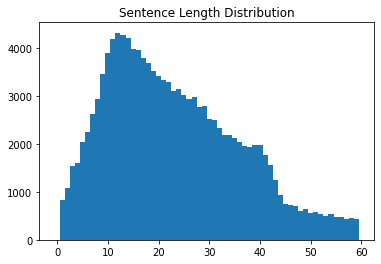

In [37]:
max_len = 60
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in train_data['document'] if (len(s) <= max_len) & (len(s) > min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [38]:
temp_file = '/content/drive/MyDrive/sp_tokenizer/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_12k --vocab_size={}'.format(temp_file, 12000)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_12k --model_type=bpe --vocab_size={}'.format(temp_file, 12000)    
)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 459287 Mar 23 04:01 korean_spm_12k.model
-rw-r--r-- 1 root root 232285 Mar 23 04:01 korean_spm_12k.vocab
-rw-r--r-- 1 root root 378586 Mar 23 04:00 korean_spm_8k.model
-rw-r--r-- 1 root root 148073 Mar 23 04:00 korean_spm_8k.vocab
-rw-r--r-- 1 root root 450824 Mar 23 04:01 korean_spm_bpe_12k.model
-rw-r--r-- 1 root root 190016 Mar 23 04:01 korean_spm_bpe_12k.vocab
-rw-r--r-- 1 root root 373762 Mar 23 04:00 korean_spm_bpe_8k.model
-rw-r--r-- 1 root root 118958 Mar 23 04:00 korean_spm_bpe_8k.vocab


### SentencePiece 실험

In [39]:
def test_spm(model):
  s = spm.SentencePieceProcessor()

  s.Load('{}.model'.format(model))
  tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
  print(tokensIDs)

  # SentencePiece를 활용한 sentence -> encoded pieces
  print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

  # SentencePiece를 활용한 encoding -> sentence 복원
  print(s.DecodeIds(tokensIDs))

In [40]:
test_spm('korean_spm_8k')

[1557, 7, 426, 11, 1402, 7, 143, 12, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [41]:
test_spm('korean_spm_bpe_8k')

[6097, 895, 6697, 6439, 1443, 6434, 6535, 6428, 0]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [42]:
test_spm('korean_spm_12k')

[1325, 7, 469, 11, 1573, 7, 162, 12, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [43]:
test_spm('korean_spm_bpe_12k')

[8925, 10697, 10439, 1443, 10434, 10535, 10428, 0]
['▁아버지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


### SentencePiece 사용하기

In [44]:
max_len = 60
def sp_tokenize(s, train_corpus, test_corpus, spm):

    spm_X_train = []
    spm_X_test = []

    for sen in train_corpus:
        spm_X_train.append([word for word in s.EncodeAsIds(sen) if not word in stopwords])

    for tsen in test_corpus:
        spm_X_test.append([word for word in s.EncodeAsIds(tsen) if not word in stopwords])

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    spm_X_train = tf.keras.preprocessing.sequence.pad_sequences(spm_X_train, padding='pre', maxlen=max_len)
    spm_X_test = tf.keras.preprocessing.sequence.pad_sequences(spm_X_test, padding='pre', maxlen=max_len)

    return spm_X_train, spm_X_test, word_index, index_word

korean_spm_bpe_12k으로 실험해보기

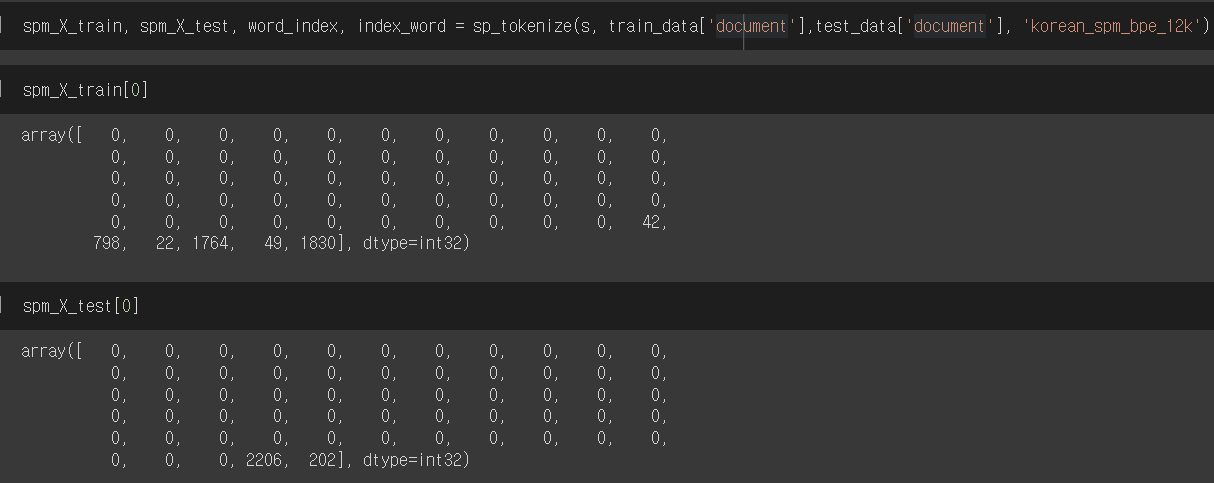

In [45]:
spm_y_train = np.array(train_data['label'])
spm_y_test = np.array(test_data['label'])

In [46]:
def sp_tokenize_models(spm_model, vocab_size, word_vector_dim):
  
  s = spm.SentencePieceProcessor()
  s.Load("{}.model".format(spm_model)) 
  spm_X_train, spm_X_test, word_index, index_word = sp_tokenize(s, train_data['document'],test_data['document'], spm_model)

  LSTM_model = tf.keras.Sequential()
  LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
  LSTM_model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
  LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
  LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

  LSTM_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

  LSTM_model.summary()

  history = LSTM_model.fit(spm_X_train, spm_y_train, epochs=15, batch_size=60, callbacks=[es], validation_split=0.2)

  eval = LSTM_model.evaluate(spm_X_test, spm_y_test)

  return history, eval

In [47]:
def spm_history(train_history):
  fig = plt.figure(figsize=(15,5))
  ax1 = fig.add_subplot(1,2,1)
  plt.plot(train_history.history['loss'], 'r', label='Training loss')
  plt.plot(train_history.history['val_loss'], 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()

  ax2 = fig.add_subplot(1,2,2)
  plt.plot(train_history.history['accuracy'], 'r', label='Training acc')
  plt.plot(train_history.history['val_accuracy'], 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()

  plt.show()

### (1) korean_spm_8k

In [48]:
korean_spm_8k_var, korean_spm_8k_eval = sp_tokenize_models('korean_spm_8k', vocab_size=8000, word_vector_dim=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          256000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 259,281
Trainable params: 259,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1944/1944 [==============================] - 21s 9ms/step - loss: 0.4025 - accuracy: 0.8142 - val_loss: 0.3444 - val_accuracy: 0.8502
Epoch 2/15
1944/1944 [===============

In [49]:
print('loss: {}, accuracy: {}'.format(korean_spm_8k_eval[0], korean_spm_8k_eval[1]))

loss: 0.3625795245170593, accuracy: 0.845637321472168


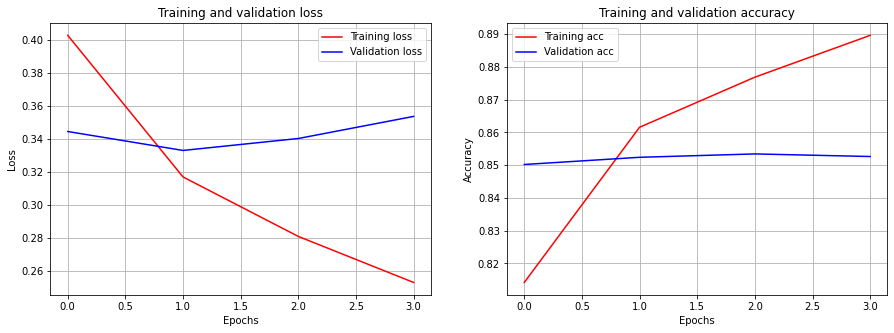

In [50]:
spm_history(korean_spm_8k_var)

### (2) korean_spm_bpm_8k

In [51]:
korean_spm_bpm_8k_var, korean_spm_bpm_8k_eval = sp_tokenize_models('korean_spm_bpe_8k', vocab_size=8000, word_vector_dim=32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          256000    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 259,281
Trainable params: 259,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1944/1944 [==============================] - 20s 9ms/step - loss: 0.4009 - accuracy: 0.8121 - val_loss: 0.3465 - val_accuracy: 0.8473
Epoch 2/15
1944/1944 [=============

In [52]:
print('loss: {}, accuracy: {}'.format(korean_spm_bpm_8k_eval[0], korean_spm_bpm_8k_eval[1]))

loss: 0.36790183186531067, accuracy: 0.847474217414856


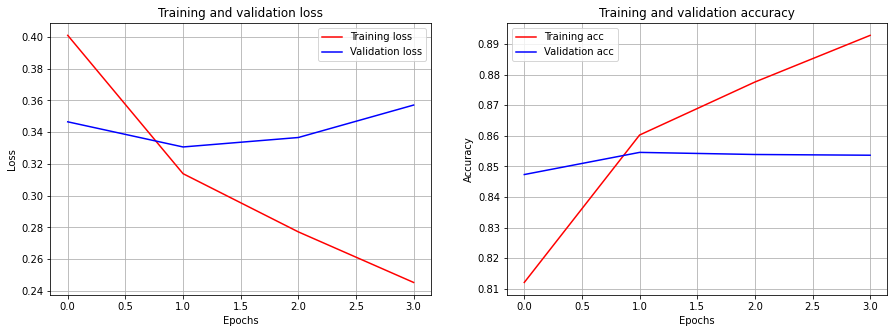

In [53]:
spm_history(korean_spm_bpm_8k_var)

### (3) korean_spm_12k

In [54]:
korean_spm_12k_var, korean_spm_12k_eval = sp_tokenize_models('korean_spm_12k', vocab_size=12000, word_vector_dim=32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          384000    
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 387,281
Trainable params: 387,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1944/1944 [==============================] - 20s 9ms/step - loss: 0.4032 - accuracy: 0.8149 - val_loss: 0.3402 - val_accuracy: 0.8514
Epoch 2/15
1944/1944 [=============

In [55]:
print('loss: {}, accuracy: {}'.format(korean_spm_12k_eval[0], korean_spm_12k_eval[1]))

loss: 0.38572457432746887, accuracy: 0.8465149402618408


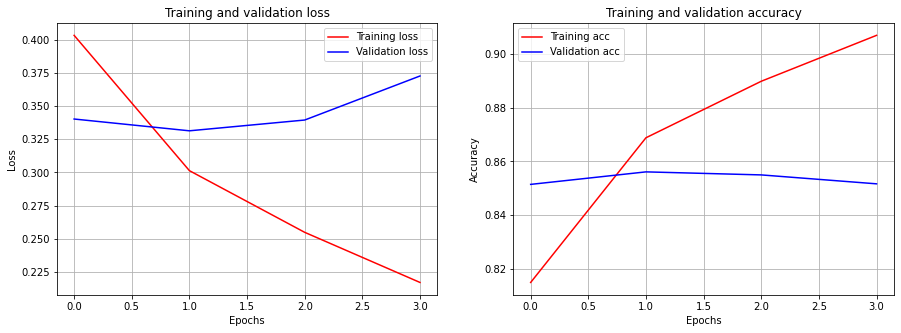

In [56]:
spm_history(korean_spm_12k_var)

### (4) korean_spm_bpm_12k

In [57]:
korean_spm_bpm_12k_var, korean_spm_bpm_12k_eval = sp_tokenize_models('korean_spm_bpe_12k', vocab_size=12000, word_vector_dim=32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          384000    
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 387,281
Trainable params: 387,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1944/1944 [==============================] - 20s 9ms/step - loss: 0.4041 - accuracy: 0.8134 - val_loss: 0.3422 - val_accuracy: 0.8489
Epoch 2/15
1944/1944 [=============

In [58]:
print('loss: {}, accuracy: {}'.format(korean_spm_bpm_12k_eval[0], korean_spm_bpm_12k_eval[1]))

loss: 0.37508994340896606, accuracy: 0.8469027280807495


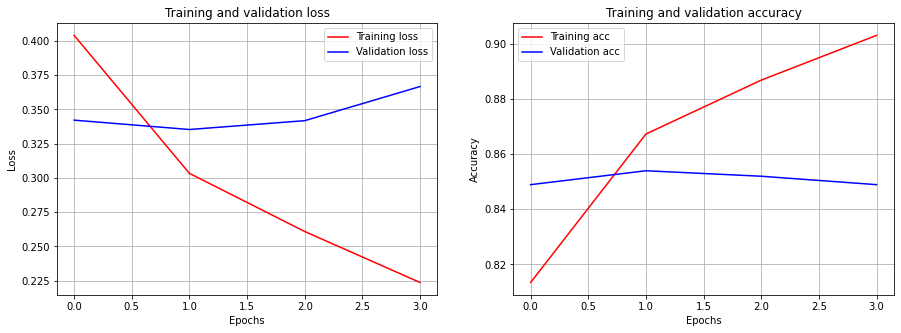

In [59]:
spm_history(korean_spm_bpm_12k_var)

## Macab(형태소 분석기)

In [60]:
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer

In [61]:
mecab = Mecab()

X_train = []
for sentence in train_data['document']:
  X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

print(X_train[:2])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나']]


In [62]:
X_test = []
for sentence in test_data['document']:
  X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

print(X_test[:2])

[['굳', 'ㅋ'], ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '점', '짜리', '더더욱', '아니', '잖아']]


In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '다': 2, '고': 3, '하': 4, '을': 5, '보': 6, '게': 7, '지': 8, '있': 9, '없': 10, '좋': 11, '나': 12, '었': 13, '만': 14, '는데': 15, '너무': 16, '봤': 17, '적': 18, '안': 19, '정말': 20, '로': 21, '것': 22, '음': 23, '아': 24, '네요': 25, '어': 26, '재밌': 27, '지만': 28, '같': 29, '진짜': 30, '에서': 31, '했': 32, '기': 33, '네': 34, '않': 35, '점': 36, '거': 37, '았': 38, '수': 39, '되': 40, '면': 41, 'ㅋㅋ': 42, '인': 43, '말': 44, '연기': 45, '주': 46, '최고': 47, '내': 48, '평점': 49, '이런': 50, '던': 51, '어요': 52, '할': 53, '왜': 54, '겠': 55, '스토리': 56, '해': 57, 'ㅋㅋㅋ': 58, '습니다': 59, '듯': 60, '아니': 61, '드라마': 62, '생각': 63, '더': 64, '그': 65, '싶': 66, '사람': 67, '때': 68, '감동': 69, '배우': 70, '함': 71, '본': 72, '까지': 73, '뭐': 74, '알': 75, '만들': 76, '내용': 77, '볼': 78, '보다': 79, '감독': 80, '라': 81, '재미': 82, '그냥': 83, '시간': 84, '지루': 85, '중': 86, '재미있': 87, '였': 88, '잼': 89, '년': 90, '사랑': 91, '못': 92, '재미없': 93, '냐': 94, '쓰레기': 95, '서': 96, '라고': 97, '니': 98, '면서': 99, '다시': 100, '번': 101, '나오': 102, '하나': 103, '작품': 104, '야': 105, '이거': 1

## 빈도수가 낮은 데이터 제거하기

In [64]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print("전체 단어 수: ", words_cnt)
print("빈도가 {} 이하인 희귀 단어 수: {}".format(threshold - 1, rare_cnt))
print("희귀 단어 비율: {}".format((rare_cnt/words_cnt)*100))
print("희귀 단어 등장 빈도 비율: {}".format((rare_freq/words_freq)*100))

전체 단어 수:  49946
빈도가 2 이하인 희귀 단어 수: 28320
희귀 단어 비율: 56.70123733632323
희귀 단어 등장 빈도 비율: 1.7606762208782198


In [65]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

21628


In [66]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [67]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [68]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

145380
145380


In [69]:
print("리뷰 최대 길이: ",max(len(l) for l in X_train))
print("리뷰 평균 길이: ",sum(map(len, X_train))/len(X_train))

리뷰 최대 길이:  83
리뷰 평균 길이:  13.801382583574082


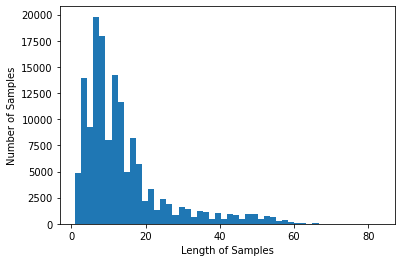

In [70]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [71]:
max_len = 60

In [72]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [73]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        25,  65, 893,  31, 212,  13,  26, 697], dtype=int32)

# 5. Mecab, LSTM 모델 사용하기

[tf.keras.layers.Embedding](https://runebook.dev/ko/docs/tensorflow/keras/layers/embedding)

In [74]:
word_vector_dim = 32

In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

LSTM_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          692096    
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 695,377
Trainable params: 695,377
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = LSTM_model.fit(X_train, y_train, epochs=15, batch_size=60, callbacks=[es], validation_split=0.2)

Epoch 1/15
1939/1939 [==============================] - 20s 9ms/step - loss: 0.3899 - accuracy: 0.8218 - val_loss: 0.3459 - val_accuracy: 0.8468
Epoch 2/15
1939/1939 [==============================] - 17s 9ms/step - loss: 0.2949 - accuracy: 0.8730 - val_loss: 0.3390 - val_accuracy: 0.8530
Epoch 3/15
1939/1939 [==============================] - 18s 9ms/step - loss: 0.2476 - accuracy: 0.8946 - val_loss: 0.3526 - val_accuracy: 0.8541
Epoch 4/15
1939/1939 [==============================] - 17s 9ms/step - loss: 0.2114 - accuracy: 0.9125 - val_loss: 0.3831 - val_accuracy: 0.8526
Epoch 4: early stopping


In [77]:
LSTM_model.evaluate(X_test, y_test)

1532/1532 [==============================] - 6s 4ms/step - loss: 0.3893 - accuracy: 0.8491


[0.3892538845539093, 0.8491478562355042]

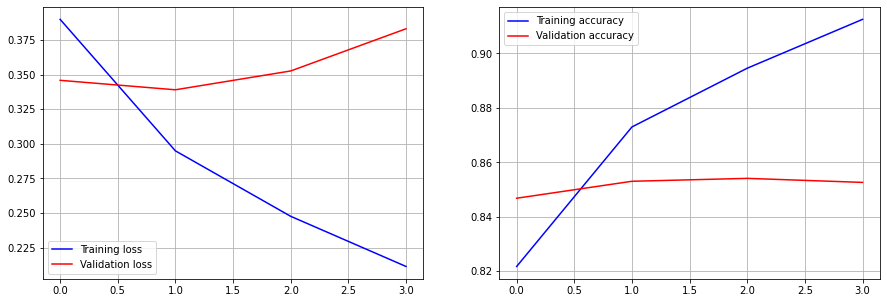

In [78]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.legend()
plt.grid()

ax2 = fig.add_subplot(1,2,2)
plt.plot(acc, 'b', label='Training accuracy')
plt.plot(val_acc, 'r', label='Validation accuracy')
plt.legend()
plt.grid()

plt.show()

# 회고

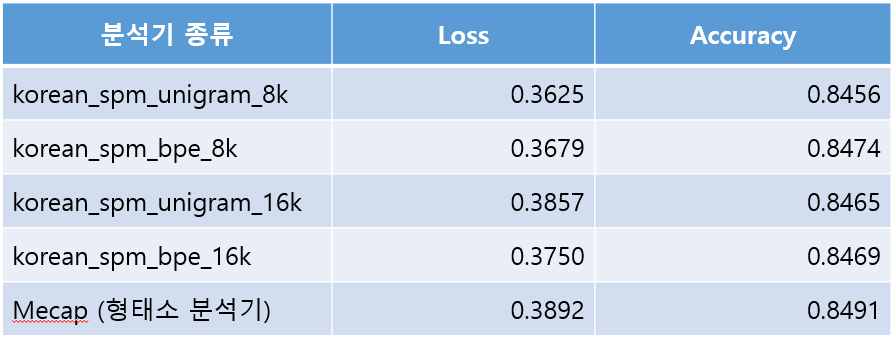

nlp에서 크게 문제가 되는 빈도가 적은 단어, OOV(out-of-vocabulary) 문제를 해결하기 위해서 SentencePiece랑 Mecab(형태소 분석기)을 사용해서 OOV 문제를 해결해보았습니다. OOV문제는 기계가 모르는 단어로 인해 문제를 풀지 못하는 문제를 말합니다. 

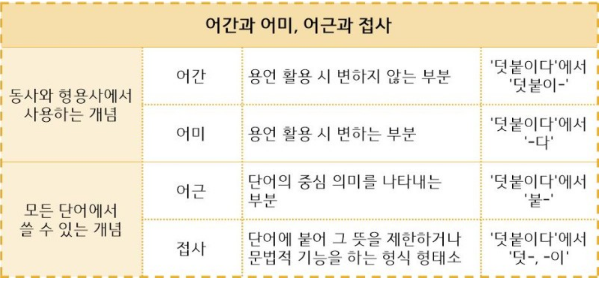

한국어는 어간, 어미, 접사, 어근으로 나눠서 해석할 수 있기 때문에 기존에 띄어쓰기로 나눈 토큰화 방법은 좋은 결과를 얻을 수 없었다는 글을 읽었습니다. 그래서 한국어는 subword로 나누는 모델인 sentencepiece를 사용해본 결과 좋은 결과를 얻을 수 있었습니다. 그리고 한국어에 특화된 형태소 분석기(mecab)을 사용해본 결과 sentencepiece보다 조금 성능이 좋았습니다. mecab이 그래도 한국어에 특화되어 있어서 sentencepiece보다 성능이 조금 더 나은 것 같습니다.

[mecab과 sentencepiece](https://www.koreascience.or.kr/article/JAKO202031837625004.pdf) 논문을 읽어본 결과, 형태소 분석 기반 토크나이저에 비해 sentencepiece 기반 토크나이저가 오타, 비문, 비표준어를 분석하는데 더 좋은 결과를 얻었다고 하는데, 이는 SentencePiece가 사람들이 주로 사용하는 동일한 음절 시퀀스에 기반하여 의미 있는 표현들을 그룹화 하기 때문에 사전에 정의되어 있지 않은 줄임말이나 은어 등과 관련된 용어에 대해서도 특정한 의미부여가 가능하다는 것을 알게 되었습니다. 이를 통해 mecab과 sentencepiece의 차이가 거의 없던 것에 대해 생각해볼 수 있었습니다. 

BPE은 기본적으로 연속적으로 가장 많이 등장한 글자의 쌍을 찾아서 하나의 글자로 병합하는 방식을 수행하는데 기존의 언어모델이 주어지면, 이에 대한 확률분포를 가지고 단어의 시퀀스를 뽑는 가장 단순한 모델인 unigram 모델의 경우 확률(학습말뭉치에 등장한 각 단어 빈도를 세어서 전체 단어수로 나누어준 것)의 총합이 1이기 때문에 단어가 많아질 경우 값의 차이가 거의 없어집니다. bpe는 이런 문제를 해결해주기 때문에 unigram보다 조금 더 좋을 결과를 얻을 수 있었던 것 같습니다.

# 참고자료

https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/09/16/LM/